In [1]:
pip install pennylane-cirq

In [2]:
import pennylane as qml

In [3]:
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [4]:
pip install qiskit -q

In [5]:
pip install qiskit -q --upgrade

In [6]:
pip install pennylane --upgrade

Requirement already up-to-date: pennylane in /usr/local/lib/python3.6/dist-packages (0.11.0)


In [7]:
pip install pennylane-qiskit

In [8]:
pip install autograd tensorflow>=1.13.2

In [9]:
import pennylane as qml
qml.about()

Name: PennyLane
Version: 0.11.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, autograd, semantic-version, scipy, networkx, appdirs, toml
Required-by: PennyLane-qiskit, PennyLane-Cirq
Platform info:           Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.6.9
Numpy version:           1.18.5
Scipy version:           1.4.1
Installed devices:
- default.gaussian (PennyLane-0.11.0)
- default.qubit (PennyLane-0.11.0)
- default.qubit.autograd (PennyLane-0.11.0)
- default.qubit.tf (PennyLane-0.11.0)
- default.tensor (PennyLane-0.11.0)
- default.tensor.tf (PennyLane-0.11.0)
- qiskit.aer (PennyLane-qiskit-0.11.0)
- qiskit.basicaer (PennyLane-qiskit-0.11.0)
- qiskit.ibmq (PennyLane-qiskit-0.11.0)
- cirq.mixedsimulator (PennyLane-Cirq-0.11.0)
- cirq.simulator (PennyL

In [12]:
dev = qml.device("cirq.mixedsimulator", wires=2)


In [13]:
A1 = qml.PauliZ(0)
A2 = qml.PauliX(0)
B1 = qml.Hermitian(np.array([[1, 1], [1, -1]]) / np.sqrt(2), wires=1)
B2 = qml.Hermitian(np.array([[1, -1], [-1, -1]]) / np.sqrt(2), wires=1)
CHSH_observables = [A1 @ B1, A1 @ B2, A2 @ B1, A2 @ B2]


In [14]:
# subcircuit for creating an entangled pair of qubits
def bell_pair():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])


In [15]:
# circuits for measuring each distinct observable
@qml.qnode(dev)
def measure_A1B1():
    bell_pair()
    return qml.expval(A1 @ B1)

@qml.qnode(dev)
def measure_A1B2():
    bell_pair()
    return qml.expval(A1 @ B2)

@qml.qnode(dev)
def measure_A2B1():
    bell_pair()
    return qml.expval(A2 @ B1)

@qml.qnode(dev)
def measure_A2B2():
    bell_pair()
    return qml.expval(A2 @ B2)

circuits = qml.QNodeCollection([measure_A1B1,
                                measure_A1B2,
                                measure_A2B1,
                                measure_A2B2])

In [16]:
expvals = circuits()

In [17]:
CHSH_expval = np.sum(expvals[:3]) - expvals[3]
print(CHSH_expval)

2.828426718711853


In [18]:
from pennylane_cirq import ops as cirq_ops
# Note that the 'Operation' op is a generic base class
# from PennyLane core.
# All other ops are provided by Cirq.
available_ops = [op for op in dir(cirq_ops) if not op.startswith('_')]
print("\n".join(available_ops))

AmplitudeDamp
BitFlip
Depolarize
Operation
PhaseDamp
PhaseFlip


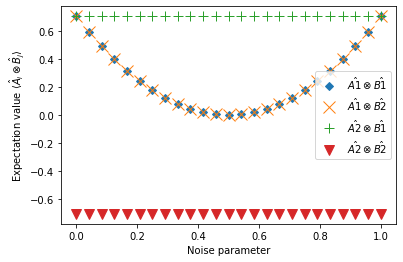

In [19]:
noise_vals = np.linspace(0, 1, 25)

CHSH_vals = []
noisy_expvals = []

for p in noise_vals:
    # we overwrite the bell_pair() subcircuit to add
    # extra noisy channels after the entangled state is created
    def bell_pair():
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0, 1])
        cirq_ops.BitFlip(p, wires=0)
        cirq_ops.BitFlip(p, wires=1)
    # measuring the circuits will now use the new noisy bell_pair() function
    expvals = circuits()
    noisy_expvals.append(expvals)
noisy_expvals = np.array(noisy_expvals)
CHSH_expvals = np.sum(noisy_expvals[:,:3], axis=1) - noisy_expvals[:,3]

# Plot the individual observables
plt.plot(noise_vals, noisy_expvals[:, 0], 'D',
         label = r"$\hat{A1}\otimes \hat{B1}$", markersize=5)
plt.plot(noise_vals, noisy_expvals[:, 1], 'x',
         label = r"$\hat{A1}\otimes \hat{B2}$", markersize=12)
plt.plot(noise_vals, noisy_expvals[:, 2], '+',
         label = r"$\hat{A2}\otimes \hat{B1}$", markersize=10)
plt.plot(noise_vals, noisy_expvals[:, 3], 'v',
         label = r"$\hat{A2}\otimes \hat{B2}$", markersize=10)
plt.xlabel('Noise parameter')
plt.ylabel(r'Expectation value $\langle \hat{A}_i\otimes\hat{B}_j\rangle$')
plt.legend()
plt.show()

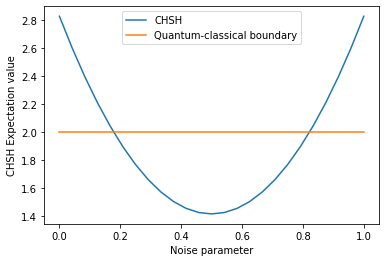

In [20]:
plt.plot(noise_vals, CHSH_expvals, label="CHSH")
plt.plot(noise_vals, 2 * np.ones_like(noise_vals),
         label="Quantum-classical boundary")
plt.xlabel('Noise parameter')
plt.ylabel('CHSH Expectation value')
plt.legend()
plt.show()

In [21]:
@qml.qnode(dev)
def circuit(gate_params, noise_param=0.0):
    qml.RX(gate_params[0], wires=0)
    qml.RY(gate_params[1], wires=0)
    cirq_ops.Depolarize(noise_param, wires=0)
    return qml.expval(qml.PauliZ(0))

gate_pars = [0.54, 0.12]
print("Expectation value:", circuit(gate_pars))

Expectation value: 0.851540632545948


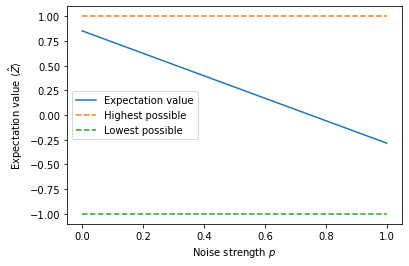

In [22]:
noise_vals = np.linspace(0., 1., 20)
expvals = [circuit(gate_pars, noise_param=p) for p in noise_vals]

plt.plot(noise_vals, expvals, label="Expectation value")
plt.plot(noise_vals, np.ones_like(noise_vals), '--', label="Highest possible")
plt.plot(noise_vals, -np.ones_like(noise_vals), '--', label="Lowest possible")
plt.ylabel(r"Expectation value $\langle \hat{Z} \rangle$")
plt.xlabel(r"Noise strength $p$")
plt.legend()
plt.show()

In [23]:
# declare the cost functions to be optimized
def cost(x):
    return circuit(x, noise_param=0.0)

def noisy_cost(x):
    return circuit(x, noise_param=0.3)

# initialize the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
init_params = np.array([0.011, 0.012])
noisy_circuit_params = init_params
params = init_params

for i in range(steps):
    # update the circuit parameters
    # we can optimize both in the same training loop
    params = opt.step(cost, params)
    noisy_circuit_params = opt.step(noisy_cost, noisy_circuit_params)

    if (i + 1) % 5 == 0:
        print("Step {:5d}. Cost: {: .7f}; Noisy Cost: {: .7f}"
              .format(i + 1,
                      cost(params),
                      noisy_cost(noisy_circuit_params)))

print("\nOptimized rotation angles (noise-free case):")
print("({: .7f}, {: .7f})".format(*params))
print("Optimized rotation angles (noisy case):")
print("({: .7f}, {: .7f})".format(*noisy_circuit_params))

Step     5. Cost:  0.9961779; Noisy Cost:  0.5993173
Step    10. Cost:  0.8974948; Noisy Cost:  0.5941737
Step    15. Cost:  0.1440492; Noisy Cost:  0.5527687
Step    20. Cost: -0.1536868; Noisy Cost:  0.3309180
Step    25. Cost: -0.9152617; Noisy Cost:  0.0470152
Step    30. Cost: -0.9994047; Noisy Cost: -0.0519407
Step    35. Cost: -0.9999964; Noisy Cost: -0.2980615
Step    40. Cost: -1.0000000; Noisy Cost: -0.5561487
Step    45. Cost: -1.0000000; Noisy Cost: -0.5969037
Step    50. Cost: -1.0000000; Noisy Cost: -0.5997996
Step    55. Cost: -1.0000000; Noisy Cost: -0.5999871
Step    60. Cost: -1.0000000; Noisy Cost: -0.5999991
Step    65. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    70. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    75. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    80. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    85. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    90. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    95. Cost: -1.0000000; Noisy Cost: -0.6